In [276]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression

# Smarter model, paper model

In [314]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["SystemCpuUsage"] + 1)#*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [315]:
def load_df_list_train():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112","results_1500/results_simple","results_1500/results_dgemm",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                    
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[10:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_list_test():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112","results_1500/results_simple",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan","results_1500/results_dgemm"]
    #directory_list=["results_1500/results_fan"]

    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                        
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[10:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list


In [316]:
df_list_train= load_df_list_train()
df = pd.concat([ i  for i in df_list_train if i is not None])

In [317]:
df["name"].unique()

array(['copy', 'copy_mem', 'copy_mem_avx', 'daxpy_mem_avx_fma',
       'stream_mem_avx_fma', 'update_avx', 'load_mem', 'load_avx',
       'store_mem', 'store_mem_avx', 'peakflops_avx_fma', 'simple',
       'dgemm', 'sleep'], dtype=object)

In [318]:
independent_variables=[ "ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	#"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

In [319]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000,atol=max(A.shape) * np.linalg.norm(A, 1) * np.spacing(1.))
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 1262.832647273035, intercept 343.74424820568555
ProbabilityScalarArithmetic 20.41731024152069
ProbabilityScalarLogic 0.0
ProbabilityScalarMemory 24.000935126304572
ProbabilityScalarBranch 0.0
ProbabilityScalarJump 0.0
ProbabilityVectorArithmetic 19.766321269633814
ProbabilityVectorMemory 24.069494980973413
ProbabilityVectorBranch 0.0
ProbabilityVectorJump 0.0


In [320]:
def assign_colors(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    color_map = plt.get_cmap('tab20')  # You can change the color map here

    label_to_color = {}
    for i, label in enumerate(unique_labels):
        label_to_color[label] = color_map(i / num_labels)

    return label_to_color
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors

{'copy': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'copy_mem': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), 'copy_mem_avx': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'daxpy_mem_avx_fma': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'dgemm': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), 'load_avx': (1.0, 0.596078431372549, 0.5882352941176471, 1.0), 'load_mem': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'peakflops_avx_fma': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'simple': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0), 'sleep': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'store_mem': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'store_mem_avx': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0), 'stream_mem_avx_fma': (0.8588235294117647, 0.8588235294117647,

(300.0, 700.0)

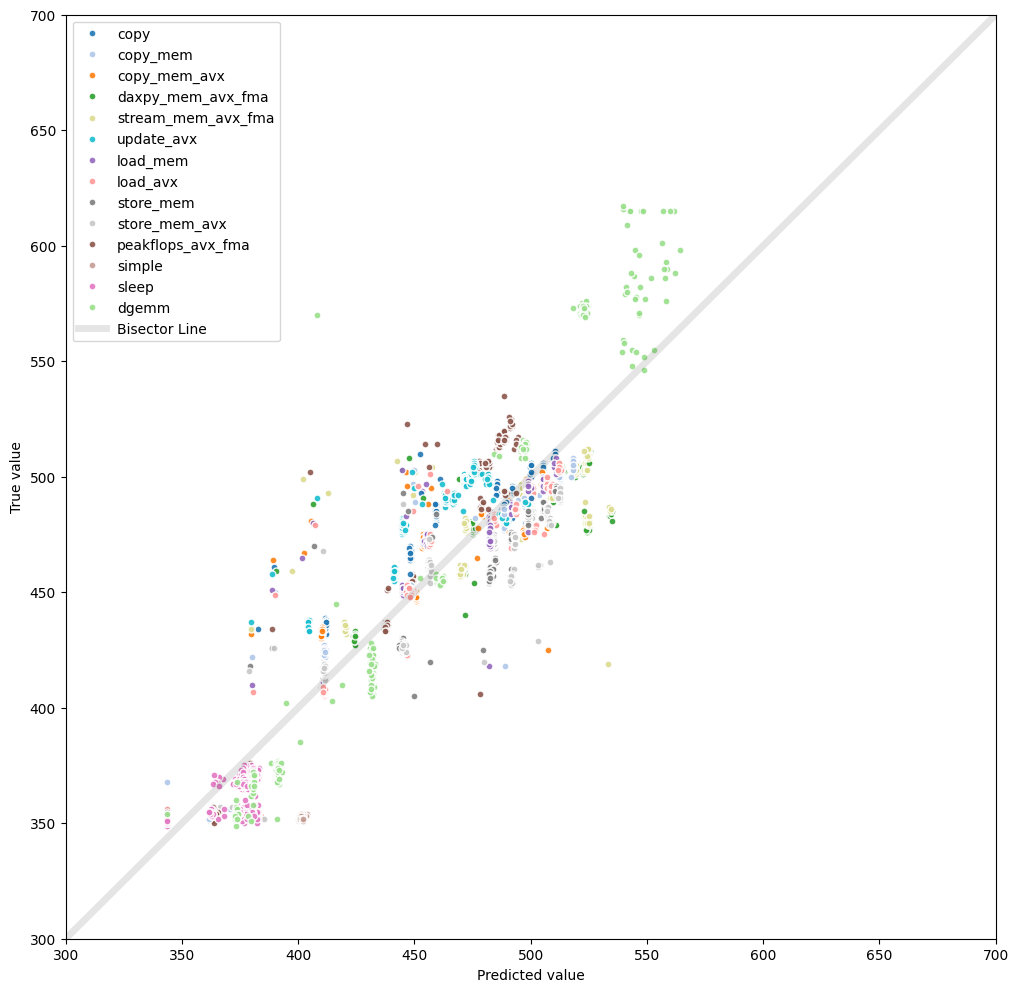

In [321]:
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                 markersize=5, 
                 alpha=0.9,
                 fillstyle='full',
                 markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

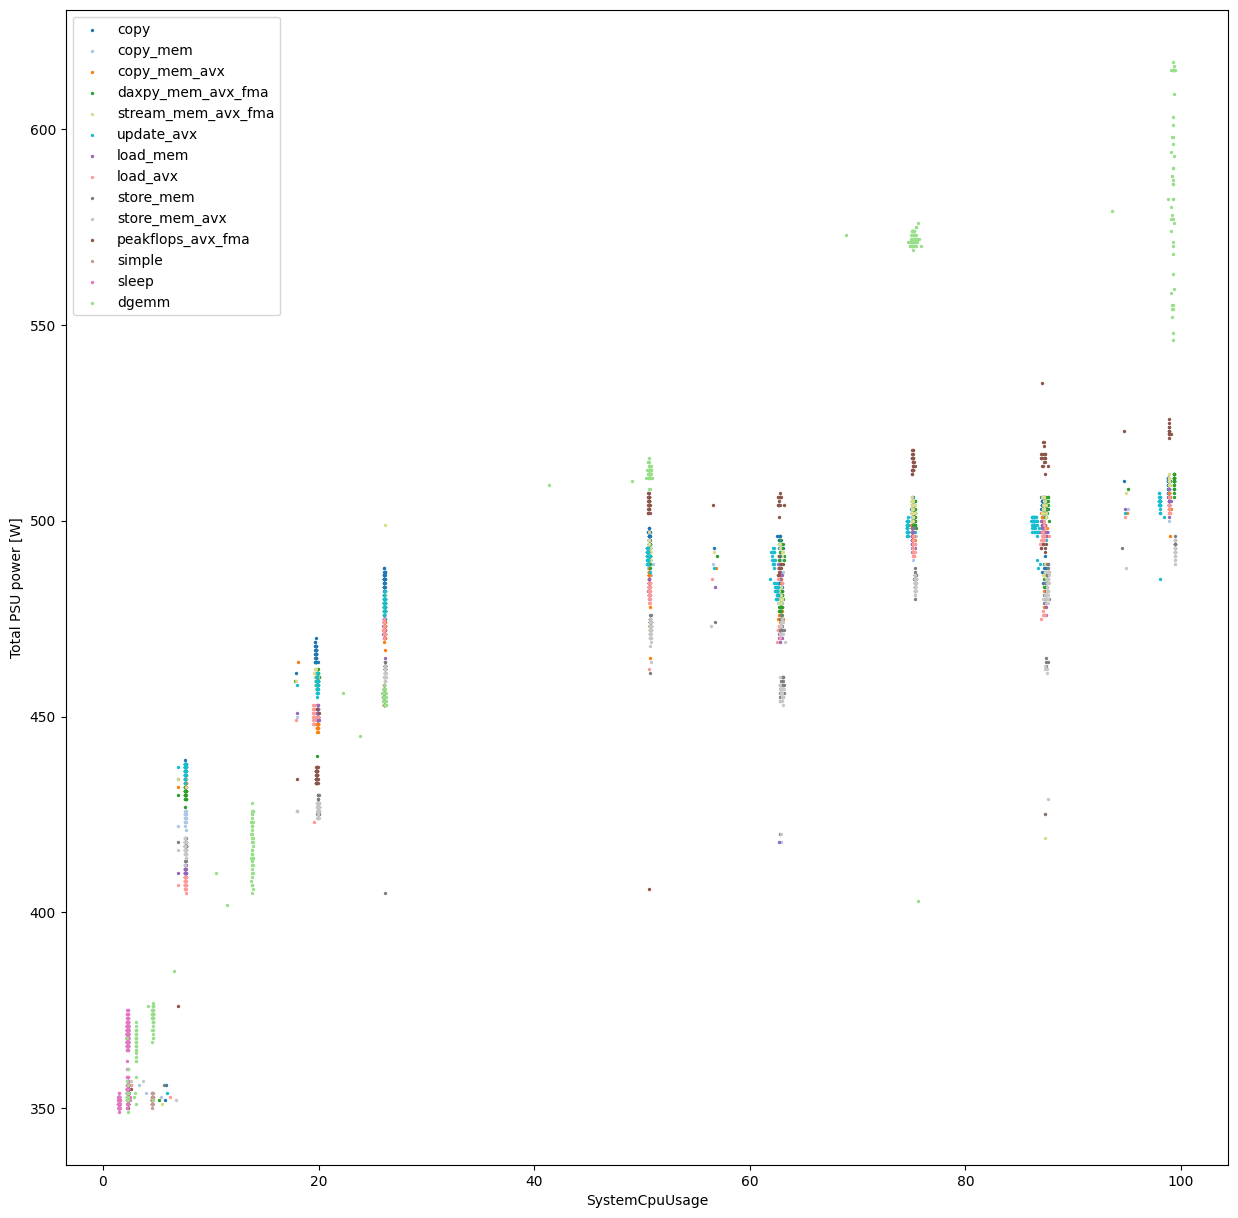

In [93]:
df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_power"] > 400)]
column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']
plt.figure(figsize=(15,15))
color=[name_to_color[i] for i in df["name"]]

for _,row in df.iterrows():
    plt.scatter(row["SystemCpuUsage"],row["total_power"],s=2,label=row["name"], color=name_to_color[row["name"]])
    
plt.ylabel("Total PSU power [W]")
plt.xlabel("SystemCpuUsage")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


[15, 30, 45, 60, 75, 90, 105, 120, 135, 150]


Text(0.5, 0, 'Categories')

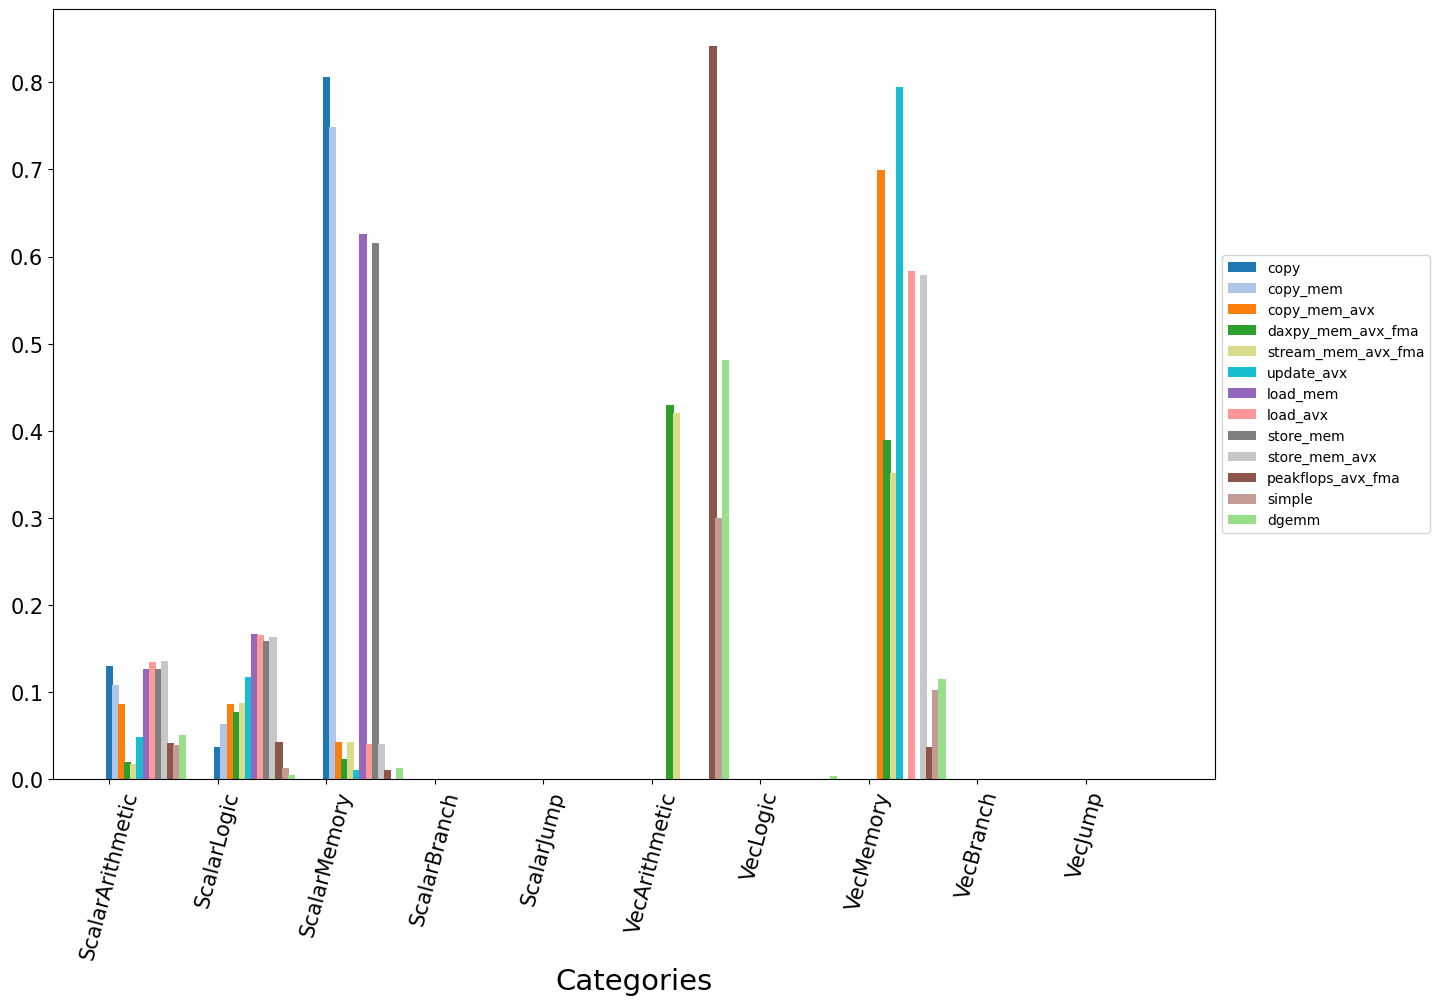

In [189]:
cores=16
independent_variables=[ "ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
column_name_probability_labels = ['ScalarArithmetic',
        'ScalarLogic',
        'ScalarMemory',
        'ScalarBranch',
        'ScalarJump',
        'VecArithmetic',
        'VecLogic',
        'VecMemory',
        'VecBranch',
        'VecJump']

tests=['copy', 'copy_mem', 'copy_mem_avx', 'daxpy_mem_avx_fma', 'stream_mem_avx_fma',
 'update_avx','load_mem', 'load_avx', 'store_mem', 'store_mem_avx',
 'peakflops_avx_fma', 'simple', 'dgemm']

df_list_test= load_df_list_train()
df=pd.concat(df_list_test)

jitter=np.array([i/len(tests) for i in range(0,len(tests))])
plt.figure(figsize=(15,10))
offset=0
ticks=list()
for var in independent_variables:
    y=list()
    offset+=15
    
    for test in tests:
        y.append(df[(df["cores"]==32) & (df["name"]==test)][var].mean()/100)
    plt.bar(jitter*11+offset,y,width=1.0,label=tests,color=[name_to_color[t] for t in tests])   
    ticks.append(offset)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
print(ticks)
plt.xticks(ticks=ticks, labels=column_name_probability_labels,fontsize=15,rotation=90-15)
plt.yticks(fontsize=15)
plt.xlabel("Categories",fontsize=21)
#        print(f"{var} {test} {y}")

In [269]:
def load_df_list_train():
    directory_list=["results_1500/results_no_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[10:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
def load_df_list_test():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[10:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
    

In [270]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000,atol=max(A.shape) * np.linalg.norm(A, 1) * np.spacing(1.))
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 120.06879393969344, intercept 384.54788754863216
ProbabilityScalarArithmetic 0.0
ProbabilityScalarLogic 878.2108851337367
ProbabilityScalarMemory 0.0
ProbabilityScalarBranch 0.0
ProbabilityScalarJump 0.0
ProbabilityVectorArithmetic 0.0
ProbabilityVectorLogic 0.0
ProbabilityVectorMemory 6362.9064788847245
ProbabilityVectorBranch 0.0
ProbabilityVectorJump 0.0


{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

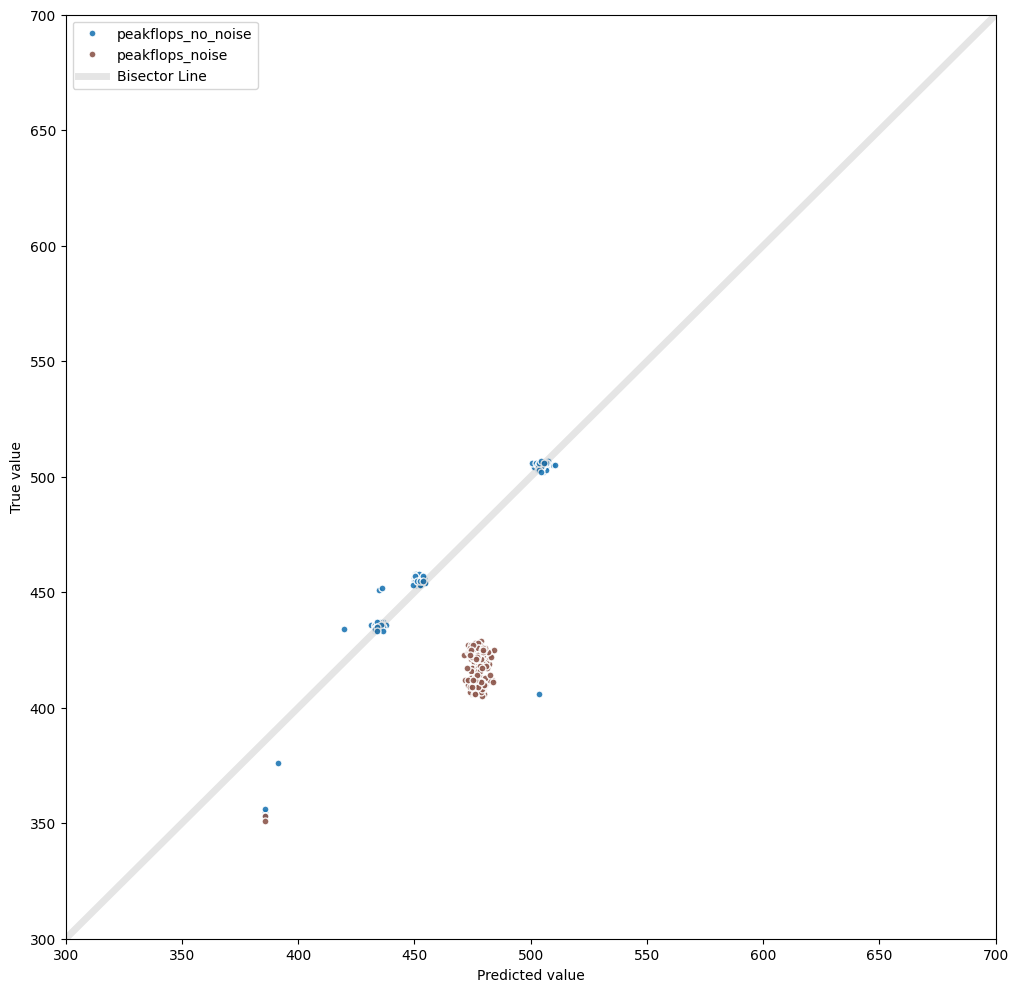

In [271]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                 markersize=5, 
                 alpha=0.9,
                 fillstyle='full',
                 markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

In [275]:
df_list_train= load_df_list_test()
df=pd.concat(df_list_train)
df[df["name"] == "peakflops_noise"]

,Timestamp,SocketPower0,SocketPower1,ProbabilityScalarArithmetic,ProbabilityScalarLogic,ProbabilityScalarMemory,ProbabilityScalarBranch,ProbabilityScalarJump,ProbabilityVectorArithmetic,ProbabilityVectorLogic,ProbabilityVectorMemory,ProbabilityVectorBranch,ProbabilityVectorJump,PSUPower0,PSUPower1,SystemCpuUsage,ProcessCpuUsage,TimeDifference,name,cores
0,471477320,106.2780,109.2730,5.22,0.53,0.44,0,0,49.01,0.34,11.87,0,0,422,5,13.6797,11.9957,7560,peakflops_noise,8
1,471484880,93.5035,96.1800,5.19,0.22,0.37,0,0,52.28,0.33,12.02,0,0,419,5,13.8281,12.3818,7560,peakflops_noise,8
2,471491520,102.5740,105.4730,5.37,0.11,0.21,0,0,52.69,0.39,12.26,0,0,415,5,13.7734,12.3526,6640,peakflops_noise,8
3,471497960,116.0510,119.4860,5.25,0.09,0.19,0,0,51.47,0.38,12.00,0,0,419,5,13.8750,12.4536,6440,peakflops_noise,8
4,471505000,96.2130,99.0651,5.34,0.08,0.18,0,0,52.46,0.31,11.98,0,0,419,5,13.8359,12.3979,7040,peakflops_noise,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,513128920,115.9530,116.5630,5.07,0.16,0.26,0,0,52.14,0.35,11.59,0,0,407,5,13.7891,12.3787,6440,peakflops_noise,64
45,513136040,96.7559,97.1713,5.48,0.09,0.25,0,0,53.30,0.35,11.66,0,0,416,5,13.9062,12.4492,7120,peakflops_noise,64
46,513142640,112.3770,112.9370,5.49,0.12,0.34,0,0,52.73,0.36,11.41,0,0,418,5,13.7734,12.3580,6600,peakflops_noise,64
47,513149680,-9211.2600,97.7362,5.32,0.07,0.23,0,0,52.78,0.32,11.94,0,0,414,5,13.7891,12.3610,7040,peakflops_noise,64
